# A real world example - Iris Classification

Here, we will learn how to implement variational quantum classifiers, that can be trained from labelled data of iris to classify new data samples.

This tutorial is inspired from [Qiskit quantum machine learning handbook](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/02a_training_a_quantum_model_on_a_real_dataset.html)

# The Iris Data Set

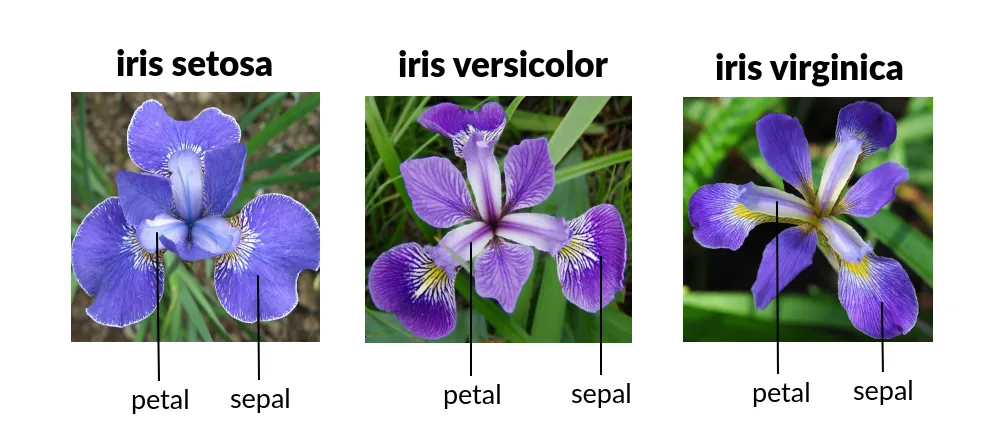

The Iris dataset serves as an excellent starting point for understanding Quantum Machine Learning (QML). It is a widely-used dataset in the machine learning community, which **contains 150 samples and designs to classify iris flowers into three species based on four key features: sepal length, sepal width, petal length, and petal width**. Here, the objective is to develop an algorithm that can automatically classify iris flowers into two species based on these measurements. The dataset is typically divided into two sets: the training set, where manipulations are performed, and the test set, where the model’s performance is evaluated.

In [1]:
from sklearn import model_selection, datasets, svm
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import qiskit
import copy

## Data

We then load the Iris data set and take a brief look at one sample of feature set (X) and label set (y).

Firstly, we’ll normalize the features. Namely, we will apply a simple transformation to represent all features on the same scale. In our case, we squeeze all features onto the interval
. Normalization is a common technique in machine learning and often leads to better numerical stability and convergence of an algorithm.

We can use MinMaxScaler from scikit-learn to perform this. Without specifying parameters, this does exactly what is required: maps data onto
.

In [2]:
iris_data = datasets.load_iris()

features = iris_data.data
labels = iris_data.target

from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

features[0], labels[0]

(array([0.22222222, 0.625     , 0.06779661, 0.04166667]), 0)

In [3]:
print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

Let’s see how our data looks. We plot the features pair-wise to see if there’s an observable correlation between them.

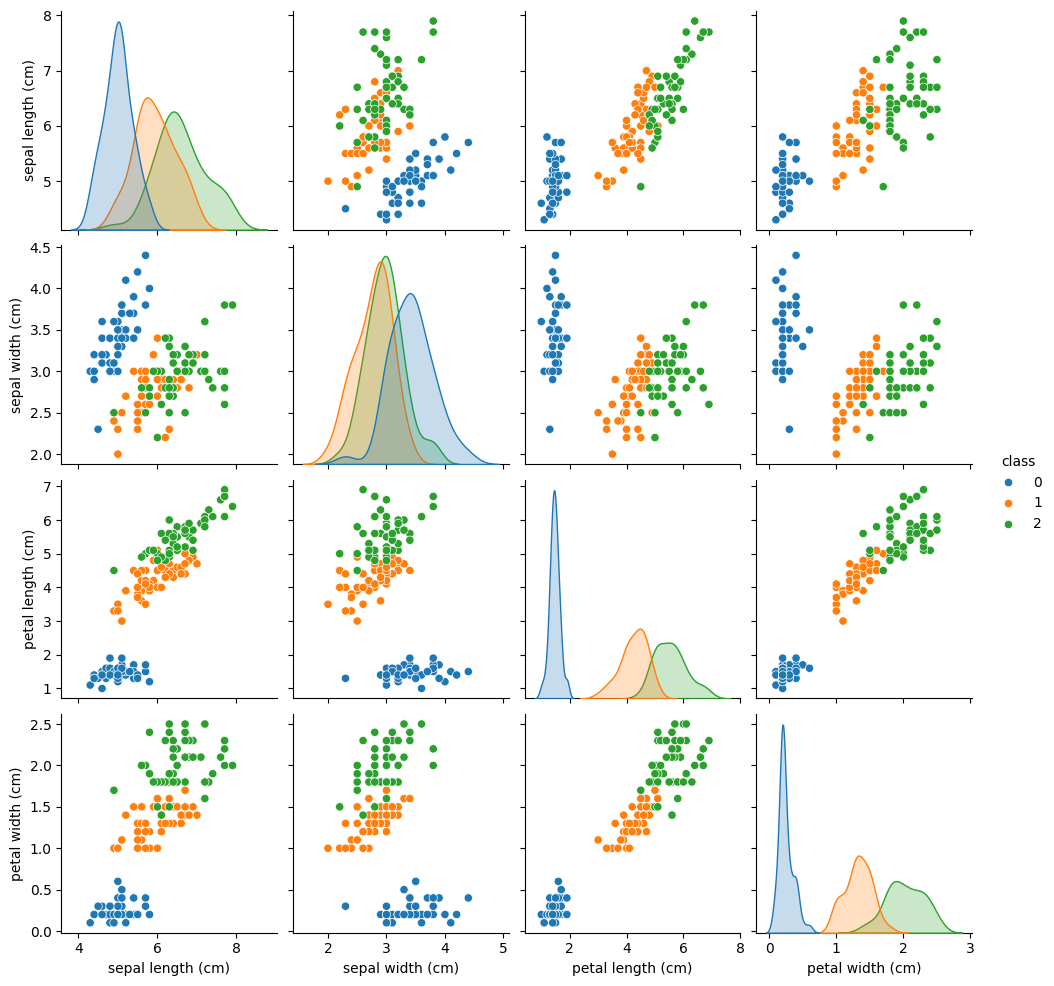

In [4]:
import pandas as pd
import seaborn as sns


df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

sns.pairplot(df, hue="class", palette="tab10")

From the plots, we see that class 0 is easily separable from the other two classes, while classes 1 and 2 are sometimes intertwined, especially regarding the “sepal width” feature.

Next, let’s see how quantum machine learning handles this dataset.

# Training a Quantum Machine Learning Model - A breif Description

As an example of a quantum model, we’ll train a variational quantum classifier (VQC). The VQC is the simplest classifier available in Qiskit Machine Learning and is a good starting point for newcomers to quantum machine learning who have a background in classical machine learning.

But before we train a model, let’s examine what comprises the VQC class. Two of its central elements are the feature map and ansatz. What these are will now be explained.

Our data is classical, meaning it consists of a set of bits, not qubits. We need a way to encode the data as qubits. This process is crucial if we want to obtain an effective quantum model. We usually refer to this mapping as data encoding, data embedding, or data loading and this is the role of the feature map. While feature mapping is a common ML mechanism, this process of loading data into quantum states does not appear in classical machine learning as that only operates in the classical world.

Once the data is loaded, we must immediately apply a parameterized quantum circuit. This circuit is a direct analog to the layers in classical neural networks. It has a set of tunable parameters or weights. The weights are optimized such that they minimize an objective function. This objective function characterizes the distance between the predictions and known labeled data.

# Using ZZFeatureMap from the Qiskit circuit library

Our choice of feature map will be the *ZZFeatureMap*. The *ZZFeatureMap** is one of the standard feature maps in the Qiskit circuit library. We pass num_features as feature_dimension, meaning the feature map will have num_features or 4 qubits.


We decompose the feature map into its constituent gates to give the reader a flavor of how feature maps may look.

As usual, we’ll first ask scikit-learn to do the train test da splitting job for us.

In [5]:
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

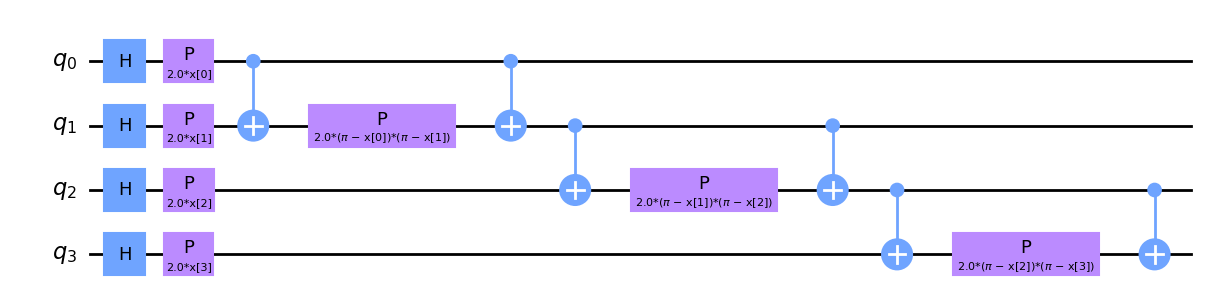

In [6]:
# ZZ FeatureMap

from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, entanglement='linear', reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

If you look closely at the feature map diagram, you will notice parameters x[0], ..., x[3]. These are placeholders for our features.



---



# Variational Circuit

## Design the ansatz


Now we create and plot our ansatz. Pay attention to the repetitive structure of the ansatz circuit. We define the number of these repetitions using the reps parameter. This circuit has 16 parameters named θ[0], ..., θ[15]. These are the trainable weights of the classifier.

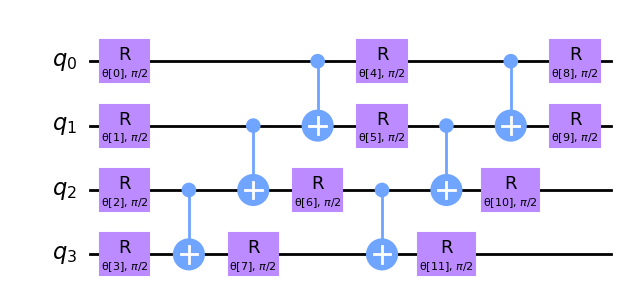

In [7]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=2, flatten=True)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

## **Pick optimizer**

We then choose an optimization algorithm to use in the training process. This step is similar to what you may find in classical deep learning frameworks. To make the training process faster, we choose a gradient-free optimizer. You may explore other optimizers available in Qiskit.

In [9]:
from qiskit_machine_learning.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

## Pick classifier - choose simulator or a real quantum computer

In the next step, we define where to train our classifier. We can train on a simulator or a real quantum computer. Here, we will use a simulator. We create an instance of the Sampler primitive from StatevectorSampler instance from qiskit.primitives. This is the reference implementation that is statevector based. Using qiskit runtime services you can create a sampler that is backed by a quantum computer.

In [10]:
from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler()

## Define callback function used as evaluation of VQC

We will add a callback function called callback_graph. VQC will call this function for each evaluation of the objective function with two parameters: the current weights and the value of the objective function at those weights. Our callback will append the value of the objective function to an array so we can plot the iteration versus the objective function value. The callback will update the plot at each iteration. Note that you can do whatever you want inside a callback function, so long as it has the two-parameter signature we mentioned above.

In [11]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# **Training**

Now we are ready to construct the classifier and fit it.

VQC stands for “variational quantum classifier.” It takes a feature map and an ansatz and constructs a quantum neural network automatically. In the simplest case it is enough to pass the number of qubits and a quantum instance to construct a valid classifier. You may omit the sampler parameter, in this case a Sampler instance will be created for you in the way we created it earlier. We created it manually for illustrative purposes only.

Training may take a few miniutes

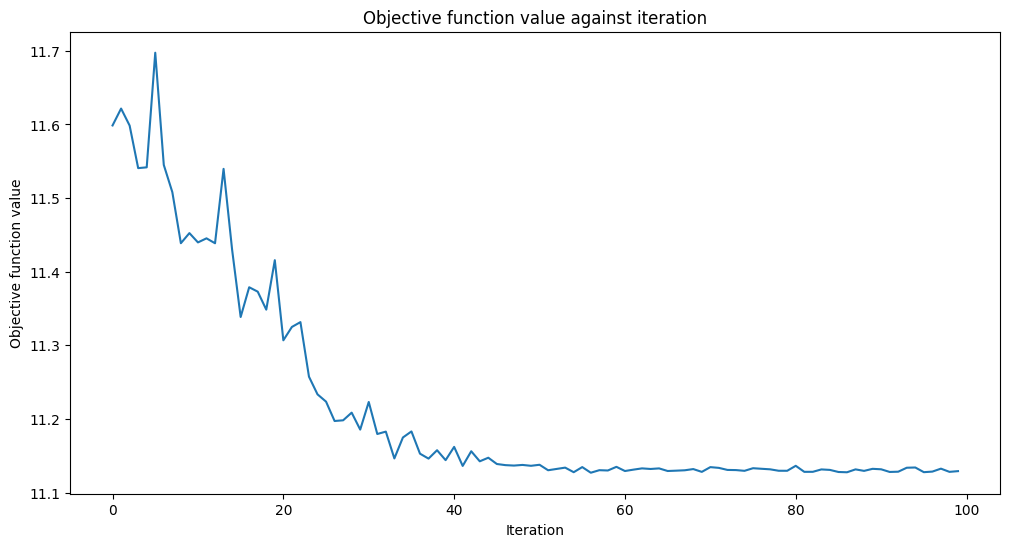

Training time: 36 seconds


In [12]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

# Performance

Let’s see how the quantum model performs on this iris dataset.

In [13]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.67
Quantum VQC on the test dataset:     0.63


As we can see, the scores are decently high for such a simple model. The model can be used to predict labels on unseen data.

# Applications in advanced research project and published paper

See [Qiskit Machine Learning tutorial](https://qiskit-community.github.io/qiskit-machine-learning/index.html)



---



---



---



In [14]:
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

# --- Section 1: Explanations (collapsible) ---
explanation_html = """
<details open>
  <summary style="font-size:16px; font-weight:bold;">📘 Explanation (Click to Collapse)</summary>
  <p>The following content is designed for easier demonstration only.</p>
  <p><strong>Highly Recommended:</strong> Do <em>not</em> run the code as it does not utilize the great power of the developed and optimized built-in functions in qiskit_quantum_machine_learning.</p>
</details>
"""
display(HTML(explanation_html))

# --- Section 2: Warning & Confirmation ---
warning = widgets.HTML(value="<b style='color:red;'>⚠️ Warning:</b> The code below may take an hour to run!")
confirm = widgets.ToggleButtons(
    options=['No', 'Yes'],
    description='Run slow code?',
    disabled=False,
    button_style='warning',
)

output = widgets.Output()

def on_confirm_change(change):
    with output:
        clear_output()
        if change['new'] == 'Yes':
            print("⏳ Running slow code... (simulated)")
            # Simulated slow code
            import time
            time.sleep(5)  # Simulate delay
            print("✅ Done! (simulated 1-hour job)")
        else:
            print("❌ Execution cancelled. The slow code was not run.")

confirm.observe(on_confirm_change, names='value')
display(warning, confirm, output)


HTML(value="<b style='color:red;'>⚠️ Warning:</b> The code below may take an hour to run!")

ToggleButtons(button_style='warning', description='Run slow code?', options=('No', 'Yes'), value='No')

Output()

# ⚠️ Slow Code Ahead - Section for explainations only - highly recommend not to run the slow code below!!

**Do not run the cells below** as they are designed to demonstrate the details steps of gradient flow, but not utilize the great power of the developed and optimized built-in functions in qiskit_quantum_machine_learning package

---



## Feature Mapping

Feature Mapping is where we translate the classical bits into quantum bits.

For the iris problem, we use angle encoding and thus rotate the qubits using rotating gates.

In [ ]:
# Change data point to different rotation

# N must be equal number of features
N = 4

def feature_map(X,N=4,C=1):

    q = QuantumRegister(N)
    c = ClassicalRegister(C)
    qc = QuantumCircuit(q,c)

    for i,x in enumerate(X):
        qc.rx(x,i)

    return qc,c

## Variational Circuit

The objective is to find the best rotation values. By experimenting with different rotation values and observing the outcomes, the quantum neural network strives to identify the rotation values that lead to the most optimized and accurate predictions.

In [ ]:
def variational_circuit(qc, theta):
    for i in range(N - 1):
        qc.cx(i, i + 1)
    qc.cx(N - 1, 0)
    for i in range(N):
        qc.ry(theta[i], i)
    return qc

## The Quantum Circuit code - operate one sample

{'1': 29, '0': 99}


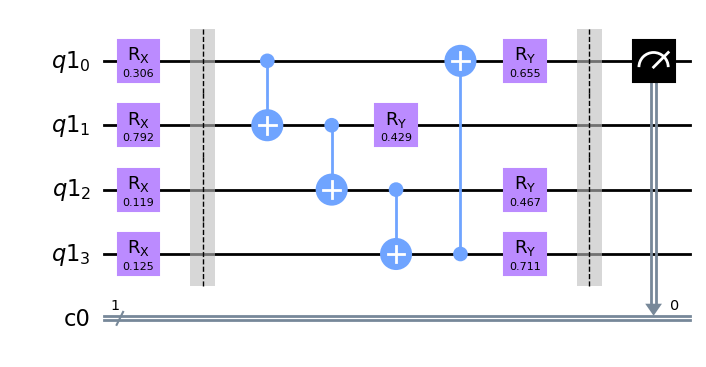

In [ ]:
qc,c = feature_map(features[5],N=4,C=1)

qc.barrier()

qc = variational_circuit(qc,np.random.rand(N))

qc.barrier()

qc.measure(0,c)

from qiskit import transpile
backend = AerSimulator()
qc_compiled = transpile(qc,backend)
job = backend.run(qc_compiled, shots = 128)
result = job.result()
counts = result.get_counts()
print(counts)

qc.draw('mpl', style='clifford')

Now we make the variational circuit code as a function 'quantum_nn'

In [ ]:
def quantum_nn(X,theta,N=4,C=1,simulator=True):

    qc,c = feature_map(X,N,C)
    qc = variational_circuit(qc,theta)
    qc.measure(0,c)

    shots = 128
    backend = AerSimulator()
    qc_compiled = transpile(qc,backend)
    job = backend.run(qc_compiled, shots = shots)
    result = job.result()
    counts = result.get_counts()

    return (counts['1']/shots)

**Define the loss function**

The loss function plays a pivotal role in quantifying the model’s errors. It calculates a number that represents how far off the guesses are from the correct answers and the goal is to minimize this number— the lower, the better.

In [ ]:
def calc_loss(prediction,target):
    return (prediction-target)**2

**Make a prediction on one sample as a test**

In [ ]:
prediction = quantum_nn(features[5],np.random.rand(N))

target = labels[5]

print('prediction value =', prediction, ', true label =', target)

prediction value = 0.3828125 , true label = 0


## **Gradient function**
Once the loss function is computed, the next step is to enhance the model’s predictions. This is where the gradient descent function comes into play. The gradient descent function facilitates a step-by-step adjustment of the predictions, similar to descending the mountain. It guides the model towards making better predictions by iteratively refining its parameters.

In [ ]:
def gradient(X_i,Y_i,theta):
    delta = 0.005
    grad = []
    dtheta = copy.copy(theta)
    for i in range(len(theta)):
        dtheta[i] += delta

        predict1 = quantum_nn(X_i,dtheta)
        predict2 = quantum_nn(X_i,theta)

        # Finite difference
        grad.append( (calc_loss(predict1,Y_i) - calc_loss(predict2,Y_i)) / delta )
    return np.array(grad)

## **Accuracy Calculation**

Evaluating the quantum neural network’s performance is a crucial step. It involves comparing the network’s predictions to the actual labels in the test dataset. This provides a quantitative measure of how well the model is classifying iris flowers into the correct species.

In [ ]:
def accuracy(X,Y,theta):
    counter = 0
    for X_i,Y_i in zip(X,Y):
        prediction = quantum_nn(X_i,theta)

        if prediction < 0.5 and Y_i == 0:
            counter += 1
        elif prediction >= 0.5 and Y_i == 1:
            counter += 1
    return (counter/len(Y))

## **Training**

**Warning!** The following computation will take long time due to not optimizing using built-in functions in specific developed package, like qiskit_quantum-machine-learning

To refine the quantum neural network’s performance, we employ a training process organized into epochs. Each epoch represents a complete pass through the training data. During each epoch, the network’s parameters, including the rotation values, are updated to improve predictive accuracy. Think of epochs as iterations or practice sessions in which the model gradually learns from previous data and makes incremental improvements over time.

In [ ]:
import time
start = time.time()

epoch = 15
eta = 0.005
loss_list = []
theta = np.ones(N)

print(f'Epoch \t Loss \t Accuracy')
for i in range(epoch):
    loss_tmp = []
    for X_i,Y_i in zip(train_features, train_labels):
        prediction = quantum_nn(X_i,theta)
        loss_tmp.append(calc_loss(prediction,Y_i))

        # Update theta
        theta = theta - eta*gradient(X_i,Y_i,theta)

    loss_list.append(np.mean(loss_tmp))
    acc = accuracy(train_features, train_labels,theta)

    print(f'{i} \t {loss_list[-1]:.3f} \t {acc:.3f}')

elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")


Epoch 	 Loss 	 Accuracy
0 	 0.277 	 0.328
1 	 0.249 	 0.731
2 	 0.210 	 0.731
3 	 0.214 	 0.716
4 	 0.236 	 0.433
5 	 0.256 	 0.328
6 	 0.250 	 0.433
7 	 0.282 	 0.567
8 	 0.280 	 0.313
9 	 0.305 	 0.299
10 	 0.313 	 0.239
11 	 0.309 	 0.299
12 	 0.300 	 0.284
13 	 0.287 	 0.313
14 	 0.270 	 0.328
15 	 0.312 	 0.269
16 	 0.312 	 0.224
17 	 0.303 	 0.209
18 	 0.281 	 0.299
19 	 0.303 	 0.388
20 	 0.285 	 0.313
21 	 0.257 	 0.552
22 	 0.246 	 0.627
23 	 0.255 	 0.343
24 	 0.292 	 0.224
25 	 0.314 	 0.284
26 	 0.315 	 0.179
27 	 0.300 	 0.343
28 	 0.274 	 0.418
29 	 0.279 	 0.254
Training time: 3388 seconds


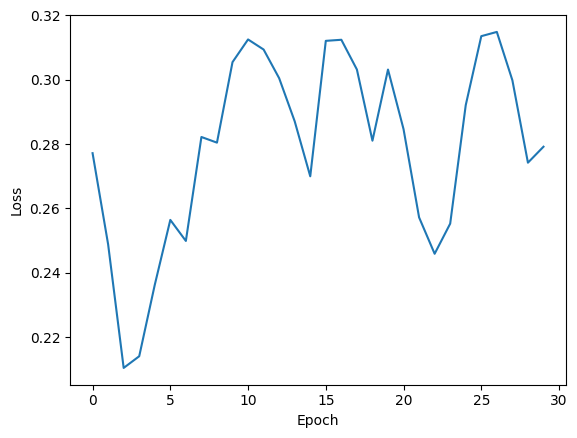

In [ ]:
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()